Profit function (Paquette Loss):  
$$\Pi:= \sum_{\textit{weeks with output } 1} 1\cdot(Close-Open)+\sum_{\textit{weeks with output } -1} -1\cdot(Close-Open)= \sum_{\textit{all weeks}} Output_{week}\cdot(Close-Open)$$

In [33]:
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader

import sys
#sys.path.append(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\anfis_libraries')
sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis')

import anfis
from membership import make_gauss_mfs, make_anfis
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [34]:
#msft = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Microsoft_weekly_ok.csv')
#amzn = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Amazon_weekly_ok.csv')
amzn = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', index_col=False, parse_dates=['Date'])
#ibm = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\IBM_weekly_ok.csv')
#cac = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Cac_weekly_ok.csv')
#sp500 = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Sp500_weekly_ok.csv')
#nasdaq = pd.read_csv(r'C:\Users\Utente\Desktop\Luiss\ML\Final Project\Datasets\Nasdaq_weekly_ok.csv')

In [35]:
amzn.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [36]:
# Function to add indicators
def calculate_indicators(df, rsi_period=14, cci_period=20, ma_short_period=10, ma_long_period=40):

    # Moving Averages with dynamic column names based on periods
    ma_short_column = f'MA{ma_short_period}'
    ma_long_column = f'MA{ma_long_period}'
    normalized_difference_column = f'MA{ma_long_period}_MA{ma_short_period}_difference_normalized'

    # Calculate short and long period moving averages
    df[ma_short_column] = df['Close'].rolling(window=ma_short_period).mean()
    df[ma_long_column] = df['Close'].rolling(window=ma_long_period).mean()

    # Calculate the normalized difference of moving averages
    df[normalized_difference_column] = (df[ma_short_column] - df[ma_long_column]) / df[ma_long_column]

    # Calculate RSI (Relative Strength Index)
    price_change = df['Close'].diff()
    upward_changes = price_change.clip(lower=0)
    downward_changes = -price_change.clip(upper=0)
    average_upward_changes = upward_changes.rolling(window=rsi_period).mean()
    average_downward_changes = downward_changes.rolling(window=rsi_period).mean()
    relative_strength = average_upward_changes / average_downward_changes
    df['RSI'] = 100 - (100 / (1 + relative_strength))

    # Calculate CCI (Commodity Channel Index)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_typical_price = typical_price.rolling(window=cci_period).mean()
    mean_deviation = (typical_price - sma_typical_price).abs().rolling(window=cci_period).mean()
    df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)

    # Calculate CPC (Current Price Change)
    rolling_mean_close = df['Close'].rolling(window=4).mean()
    df['CPC'] = 1 / (1 + np.exp(-(df['Close'] - rolling_mean_close.shift(1)) / rolling_mean_close.shift(1) * 100))
    
    df.drop(columns=[ma_short_column, ma_long_column], inplace=True)
    
    return df

In [37]:
# List of DataFrames
#dfs = [amzn, cac, ibm, msft, nasdaq, sp500]
dfs=[amzn]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)
    
    calculate_indicators(df)

In [38]:
amzn.head(41)

,Date,Open,High,Low,Close,MA40_MA10_difference_normalized,RSI,CCI,CPC
0,1997-05-18,0.075000,0.125000,0.075000,0.086460,NaN,NaN,NaN,NaN
1,1997-05-25,0.088021,0.088542,0.065625,0.075000,NaN,NaN,NaN,NaN
2,1997-06-01,0.075521,0.082292,0.072917,0.075000,NaN,NaN,NaN,NaN
3,1997-06-08,0.075521,0.085417,0.068750,0.082815,NaN,NaN,NaN,NaN
4,1997-06-15,0.082812,0.085417,0.076562,0.079170,NaN,NaN,NaN,0.307299
5,1997-06-22,0.080208,0.080208,0.074740,0.076305,NaN,NaN,NaN,0.102627
6,1997-06-29,0.077083,0.077083,0.073958,0.074480,NaN,NaN,NaN,0.007348
7,1997-07-06,0.075521,0.095833,0.073958,0.095575,NaN,NaN,NaN,1.000000
8,1997-07-13,0.091667,0.128646,0.091667,0.114585,NaN,NaN,NaN,1.000000
9,1997-07-20,0.116146,0.124740,0.105729,0.107815,NaN,NaN,NaN,1.000000


In [39]:
# Drop rows with na, depending on parameters chosen for indicators
amzn.drop(index=amzn.index[0:39], inplace=True)
amzn.reset_index(inplace=True)

In [40]:
amzn.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close',
       'MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC'],
      dtype='object')

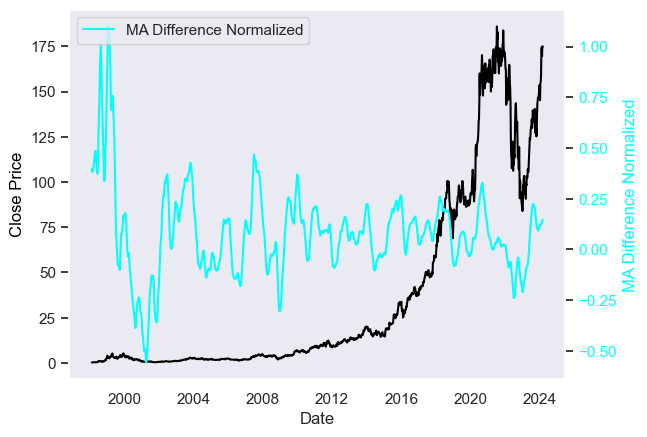

In [41]:
sns.set(style="dark")

fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['MA40_MA10_difference_normalized'], color='cyan', label='MA Difference Normalized')
ax2.set_ylabel('MA Difference Normalized', color='cyan')
ax2.tick_params(axis='y', labelcolor='cyan')
ax2.legend(loc='upper left')

plt.show()

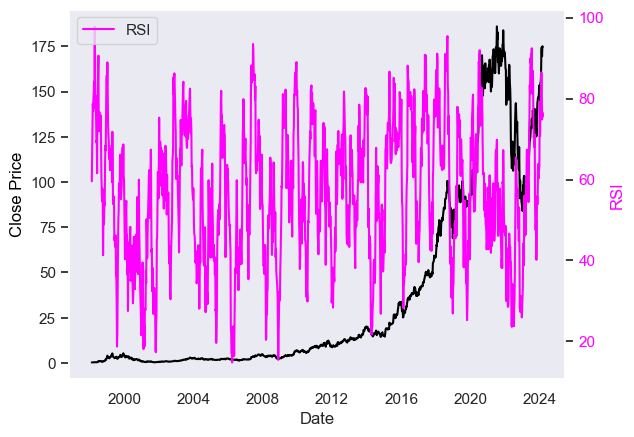

In [42]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='magenta', label='RSI')
ax2.set_ylabel('RSI', color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')
ax2.legend(loc='upper left')

plt.show()

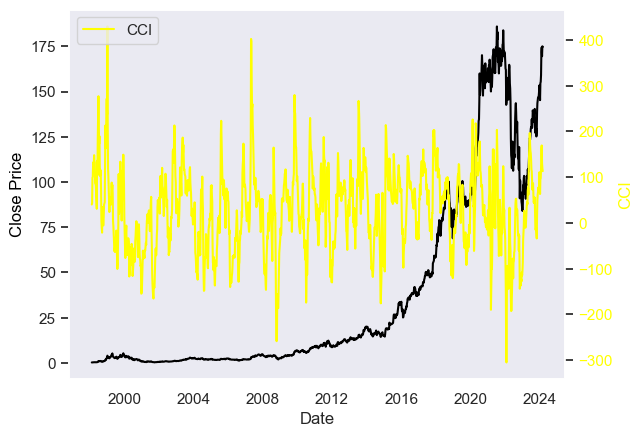

In [43]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='yellow', label='CCI')
ax2.set_ylabel('CCI', color='yellow')
ax2.tick_params(axis='y', labelcolor='yellow')
ax2.legend(loc='upper left')

plt.show()

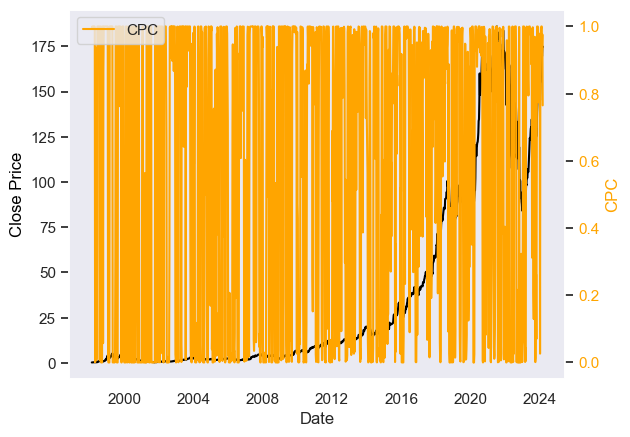

In [44]:
fig, ax = plt.subplots()
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')
#ax.tick_params(axis='y', labelcolor='white')
#ax.legend()

ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='orange', label='CPC')
ax2.set_ylabel('CPC', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper left')

plt.show()

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

In [45]:
# Calculate the percentage change in closing price from one week to the next
amzn['Next_week_pct_change'] = amzn['Close'].pct_change(periods=1).shift(-1)

# Define a threshold for what we consider to be a flat week, e.g. 1% price change
# Define a function to categorize the change as +1, 0, or -1
def categorize_change(weekly_return, flat_threshold=0.01):
    if weekly_return > flat_threshold:
        return 1  # Bullish
    elif weekly_return < -flat_threshold:
        return -1  # Bearish
    else:
        return 0  # Flat

# Apply the function to the percentage change column to create the target variable
amzn['Next_week_market_behavior'] = amzn['Next_week_pct_change'].apply(categorize_change)

# Drop the last row as it contains NaN in the 'Next_week_pct_change' column
amzn = amzn[:-1]

In [46]:
amzn

,index,Date,Open,High,Low,Close,MA40_MA10_difference_normalized,RSI,CCI,CPC,Next_week_pct_change,Next_week_market_behavior
0,39,1998-02-15,0.245833,0.273177,0.238542,0.259375,0.395743,59.549683,40.398012,0.997820,0.016077,1
1,40,1998-02-22,0.260937,0.264583,0.252604,0.263545,0.381240,65.867678,43.527506,0.996641,0.217382,1
2,41,1998-03-01,0.264583,0.331771,0.260417,0.320835,0.387294,72.396160,98.693459,1.000000,-0.003242,0
3,42,1998-03-08,0.316146,0.328125,0.291667,0.319795,0.392028,78.683845,100.946250,1.000000,0.025235,1
4,43,1998-03-15,0.320312,0.367708,0.319792,0.327865,0.389265,76.889157,128.911091,0.999997,0.067513,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1354,1393,2024-01-28,156.890000,160.720000,153.900000,159.120000,0.122564,83.740807,117.881785,0.992096,0.079751,1
1355,1394,2024-02-04,159.340000,172.500000,154.810000,171.810000,0.127295,86.463677,162.285928,0.999993,0.015366,1
1356,1395,2024-02-11,170.200000,175.000000,167.650000,174.450000,0.133117,84.332503,169.431959,0.999861,-0.028318,-1
1357,1396,2024-02-18,174.800000,175.390000,165.750000,169.510000,0.136922,74.861084,130.653961,0.932225,0.032328,1


In [47]:
# Define your feature columns
feature_columns = ['MA40_MA10_difference_normalized', 'RSI', 'CCI', 'CPC']

# Now let's prepare the features
features = amzn[feature_columns]

# Prepare the target
target = amzn['Next_week_market_behavior']

# Calculate the index for the split
split_idx = int(len(features) * 0.8)

# Split the features and target into training/testing sets without shuffling
X_train = features.iloc[:split_idx]
X_test = features.iloc[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train.values), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test.values), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
# Create the ANFIS model
model = make_anfis(X_train_tensor, num_mfs, num_output)

# Define the number of epochs - the number of times the entire dataset will be passed through the network
num_epochs = 50  # You can adjust this based on your specific requirements

# Define log interval for printing out the loss during training
log_interval = 10  # This will print out the loss after every 10 batches

# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Loss function
criterion = torch.nn.MSELoss()  # For regression tasks

# Training loop
for epoch in range(num_epochs):
    model.train()  # Sets the model to training mode (important for things like dropout, batchnorm etc.)
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Clears existing gradients from previous epoch
        output = model(data)  # Pass the data through the model
        loss = criterion(output, target)  # Compute the loss
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Adjust model weights

        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")